# 에어비앤비 가격 예측을 통한 숙박 가격에 미치는 요인 분석

대회 링크 <br>
https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data <br>

nyc traffic volumne 2014-2019 <br>
https://data.cityofnewyork.us/Transportation/Traffic-Volume-Counts-2014-2019-/ertz-hr4r

nyc taxi data <br>
https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

# Inspiration
- What can we learn about different hosts and areas?
- What can we learn from predictions? (ex: locations, prices, reviews, etc)
- Which hosts are the busiest and why?
- Is there any noticeable difference of traffic among different areas and what could be the reason for it?

# 1. 라이브러리 및 모듈 불러오기

In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
from os.path import join

# 2. 데이터 가져오기

In [89]:
data_path = join("data", "AB_NYC_2019.csv")
airbnb_df = pd.read_csv(data_path)

In [90]:
print(airbnb_df.shape)
airbnb_df.head(3)

(48895, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365


In [167]:
airbnb_df["host_id"].value_counts()

219517861    327
107434423    232
30283594     121
137358866    103
16098958      96
            ... 
26676357       1
43311385       1
544621         1
21573063       1
68119814       1
Name: host_id, Length: 37425, dtype: int64

In [91]:
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

# 3. 결측치 처리

## 3.1 name, host_name 결측치 데이터 처리

**<div style="font-size: 16px">현재 분석에선 다음 2가지 이유로 name, host_name 결측치 데이터를 제거하도록 하겠습니다.</div>**
- 가게명과 호스트 이름은 중요의 여부를 떠나 결측치가 존재하는 데이터는 사용할 수 없습니다.
- 전체 48895개의 데이터 중 37개 데이터는 전체 데이터에 크게 영향을 미치지 않을거라 판단했습니다.

In [92]:
airbnb_df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [93]:
airbnb_df = airbnb_df.loc[~(airbnb_df["name"].isnull() | airbnb_df["host_name"].isnull()), :]
airbnb_df = airbnb_df.reset_index(drop=True)

In [94]:
# 잘 처리 되었는지 확인합니다.
airbnb_df.isnull().sum()

id                                    0
name                                  0
host_id                               0
host_name                             0
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10037
reviews_per_month                 10037
calculated_host_listings_count        0
availability_365                      0
dtype: int64

## 3.2 last_review, reviews_per_month 결측치 처리

- 마지막 리뷰가 없는 데이터가 왜 존재할까 생각해봤을 때, 애초에 리뷰가 없는 상품일 수 있습니다. <br>
또한 만약 애초에 리뷰가 없는 상품이라면 자연스럽게 월별 리뷰 수도 결측치일 것입니다. <br>
추측이 맞는지 검증해보도록 하겠습니다.

In [95]:
airbnb_df[airbnb_df["last_review"].isnull()]["number_of_reviews"].max()

0

In [96]:
# last_review가 없으면 reviews_per_month도 없습니다.
list(airbnb_df[airbnb_df["last_review"].isnull()].index) == list(airbnb_df[airbnb_df["reviews_per_month"].isnull()].index)

True

- 마지막 리뷰 날짜 데이터를 연월일로 나눈 다음, 결측치를 한 번에 0으로 처리하겠습니다.

In [97]:
airbnb_df["last_review"]       = airbnb_df["last_review"].astype("datetime64")
airbnb_df["last_review_year"]  = airbnb_df["last_review"].dt.year
airbnb_df["last_review_month"] = airbnb_df["last_review"].dt.month
airbnb_df["last_review_day"]   = airbnb_df["last_review"].dt.day

airbnb_df = airbnb_df.drop(["last_review"], axis=1)
airbnb_df.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,last_review_year,last_review_month,last_review_day
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,2018.0,10.0,19.0
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355,2019.0,5.0,21.0
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365,NaN,NaN,NaN


In [98]:
airbnb_df.isnull().sum()

id                                    0
name                                  0
host_id                               0
host_name                             0
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10037
calculated_host_listings_count        0
availability_365                      0
last_review_year                  10037
last_review_month                 10037
last_review_day                   10037
dtype: int64

In [99]:
airbnb_df = airbnb_df.fillna(0)
airbnb_df.isnull().sum()

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
last_review_year                  0
last_review_month                 0
last_review_day                   0
dtype: int64

In [100]:
airbnb_df.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,last_review_year,last_review_month,last_review_day
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,2018.0,10.0,19.0
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355,2019.0,5.0,21.0
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365,0.0,0.0,0.0


# 4. 둘러보기

- correlation을 출력했을 때, price와 상관관계가 존재하는 변수는 없는 것을 볼 수 있습니다.

In [121]:
airbnb_df.corrwith(airbnb_df["price"])

id                                0.010564
host_id                           0.015328
latitude                          0.033944
longitude                        -0.149954
price                             1.000000
minimum_nights                    0.042804
number_of_reviews                -0.047949
reviews_per_month                -0.050586
calculated_host_listings_count    0.057460
availability_365                  0.081817
last_review_year                 -0.085220
last_review_month                -0.061363
last_review_day                  -0.054289
dtype: float64

In [133]:
airbnb_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,last_review_year,last_review_month,last_review_day
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,2018.0,10.0,19.0
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355,2019.0,5.0,21.0
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365,0.0,0.0,0.0
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194,2019.0,7.0,5.0
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0,2018.0,11.0,19.0


In [162]:
# airbnb_df["minimum_nights"][airbnb_df["minimum_nights"] > 30]
print((airbnb_df["minimum_nights"] > 30).sum())
print((airbnb_df["minimum_nights"] >= 30).sum())

746
4505


In [171]:
airbnb_df["host_id"].value_counts()

219517861    327
107434423    232
30283594     121
137358866    103
16098958      96
            ... 
26676357       1
43311385       1
544621         1
21573063       1
68119814       1
Name: host_id, Length: 37425, dtype: int64

In [172]:
airbnb_df["room_type"].value_counts()

Entire home/apt    25393
Private room       22306
Shared room         1159
Name: room_type, dtype: int64

In [ ]:
airbnb_df["minimum_nights"]

In [182]:
print(airbnb_df[airbnb_df["minimum_nights"] >= 100]["price"].mean())
print(airbnb_df[airbnb_df["minimum_nights"] >= 30]["price"].mean())
print(airbnb_df[airbnb_df["minimum_nights"] < 30]["price"].mean())

322.2074468085106
191.86903440621532
148.7659459337587


<AxesSubplot:xlabel='room_type', ylabel='price'>

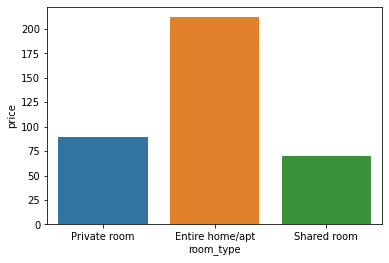

In [173]:
sns.barplot(x=airbnb_df["room_type"], y=airbnb_df["price"], ci=None)

nyc taxi 데이터
nyc aribnb

airbnb 택시가 다니는 경로에 만약 에어비엔비가 많다면? 할 게 없지 않나?